RNN & LSTM on amazon food reviews dataset

In [1]:
# Importing the basic packages to handle data
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import kagglehub
import os

In [2]:
# Downloading the csv file from kagglehub and reading as Dataframe

path = kagglehub.dataset_download('snap/amazon-fine-food-reviews')
df = pd.read_csv(os.path.join(path, 'Reviews.csv'))

In [3]:
df.head(2) # Top 2 data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [4]:
# We're going ti use only Text and Score column for now. 

df_copy = df[['Score', 'Text']]

In [5]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   568454 non-null  int64 
 1   Text    568454 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


In [6]:
# Score counts

score_count = df_copy.Score.value_counts().sort_index()

for star, count in enumerate(score_count):
    print(f'Total {star}  is {round(count/len(df_copy)*100, 2)}')

Total 0  is 9.19
Total 1  is 5.24
Total 2  is 7.5
Total 3  is 14.19
Total 4  is 63.88


In [7]:
# 3 is neutral rating so, considering below 3 as negative rating and above as positive
df_copy = df_copy[df_copy.Score !=3]
df_copy['Sentiment'] = (df_copy.Score >3).astype('int32')

In [8]:
df_copy.Sentiment.value_counts()

Sentiment
1    443777
0     82037
Name: count, dtype: int64

In [9]:
# Sample is not balance. 

from sklearn.utils import resample

In [10]:
positive_reviews = df_copy[df_copy.Sentiment == 1]
negative_reviews = df_copy[df_copy.Sentiment == 0]

positive_downsample = resample(positive_reviews, replace=False, n_samples=len(negative_reviews), random_state=42)

df_balanced = pd.concat([positive_downsample, negative_reviews])
df_balanced = df_balanced.sample(frac=1, random_state = 50).reset_index(drop=True) # Shuffling the dataset

In [11]:
# Balnaced Dataset
df_balanced.Sentiment.value_counts()

Sentiment
0    82037
1    82037
Name: count, dtype: int64

In [19]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join(text.split())
    return text

In [20]:
df_balanced.Text = df_balanced.Text.apply(clean_text)

In [22]:
# Importing the tensorflow packages to build RNN architicutre 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
# Defining vocobulary size and length of padding
voc_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words = voc_size, oov_token = '<OOV>')

X = df_balanced['Text'].values
Y = df_balanced['Sentiment'].values

tokenizer.fit_on_texts(X)
x_seq = tokenizer.texts_to_sequences(X)
x_pad = pad_sequences(x_seq, maxlen = max_len, padding = 'post', truncating = 'post')

In [28]:
print(f'Total vocobulary size {len(tokenizer.word_index)}')
print(f'Input feature size after padding {x_pad.shape}')

Total vocobulary size 114373
Input feature size after padding (164074, 100)


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

x_train, x_test, y_train, y_test = train_test_split(x_pad, Y, random_state=100, test_size=0.20, stratify=Y)

In [32]:
rnn_model = Sequential([
    Embedding(input_dim=voc_size, input_length = max_len, output_dim=128),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [34]:
early_stopping= EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights=True,)

In [ ]:
rnn_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split = 0.20, callbacks=[early_stopping])

Epoch 1/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.5235 - loss: 0.6927 - val_accuracy: 0.5625 - val_loss: 0.6728
Epoch 2/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.5394 - loss: 0.6915 - val_accuracy: 0.5524 - val_loss: 0.6749
Epoch 3/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.6169 - loss: 0.6156 - val_accuracy: 0.6533 - val_loss: 0.6302
Epoch 4/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6528 - loss: 0.5776 - val_accuracy: 0.5611 - val_loss: 0.7236
Epoch 5/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.6552 - loss: 0.5356 - val_accuracy: 0.5685 - val_loss: 0.7773
Epoch 6/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6781 - loss: 0.5052 - val_accuracy: 0.5724 - val_loss: 0.8602


RNN model training visualisation


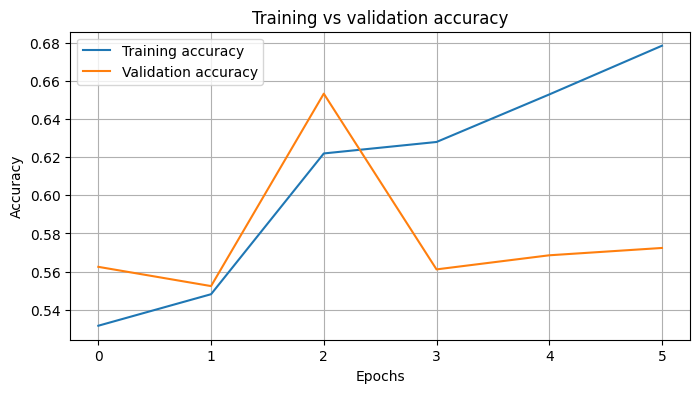

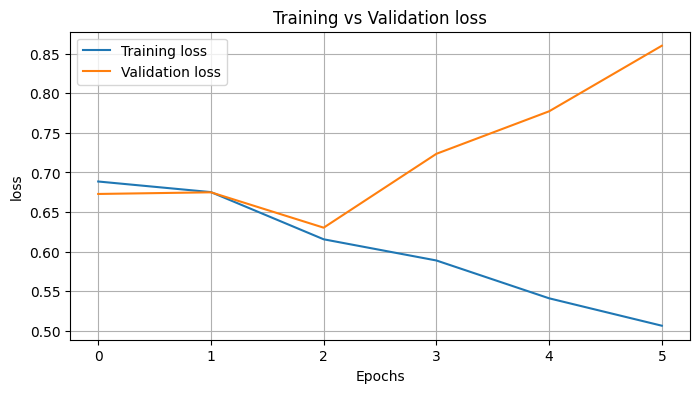

In [42]:
# visualizing the training loss, accuracy vs validation loss and accuracy

import matplotlib.pyplot as plt


print('RNN model training visualisation')

plt.figure(figsize=(8, 4))

plt.title('Training vs validation accuracy')
plt.plot(rnn_history.history['accuracy'], label = 'Training accuracy')
plt.plot(rnn_history.history['val_accuracy'], label= 'Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()


plt.figure(figsize=(8, 4))
plt.title('Training vs Validation loss')
plt.plot(rnn_history.history['loss'], label='Training loss')
plt.plot(rnn_history.history['val_loss'], label= 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()


In [47]:
lstm_model = Sequential([
    Embedding(input_dim=voc_size, output_dim= 256, input_length = max_len),
    LSTM(units=128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [48]:
lstm_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(x_train, y_train, validation_split = 0.20, callbacks=[early_stopping], epochs=10)

Epoch 1/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 116s 35ms/step - accuracy: 0.6153 - loss: 0.6051 - val_accuracy: 0.8961 - val_loss: 0.2546
Epoch 2/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 121s 37ms/step - accuracy: 0.9177 - loss: 0.2113 - val_accuracy: 0.9096 - val_loss: 0.2250
Epoch 3/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 146s 44ms/step - accuracy: 0.9442 - loss: 0.1501 - val_accuracy: 0.9211 - val_loss: 0.2152
Epoch 4/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 119s 36ms/step - accuracy: 0.9618 - loss: 0.1085 - val_accuracy: 0.9216 - val_loss: 0.2314
Epoch 5/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 142s 43ms/step - accuracy: 0.9742 - loss: 0.0761 - val_accuracy: 0.9219 - val_loss: 0.2471
Epoch 6/10
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 115s 35ms/step - accuracy: 0.9827 - loss: 0.0539 - val_accuracy: 0.9212 - val_loss: 0.2692


In [50]:
print(f'RNN model perfomance: {rnn_model.evaluate(x_test, y_test, verbose=0)}')

RNN model perfomance: [0.6277696490287781, 0.6543349027633667]


In [51]:
print(f'LSTM model perfomance: {lstm_model.evaluate(x_test, y_test, verbose=0)}')

LSTM model perfomance: [0.20721635222434998, 0.9227487444877625]


In [57]:
y_pred = lstm_model.predict(x_test) 
y_pred_class = [1 if prob >= 0.5 else 0 for prob in y_pred]

1026/1026 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


In [59]:
cm = confusion_matrix(y_test, y_pred_class)
cm

array([[15253,  1155],
       [ 1380, 15027]])

In [61]:
print(classification_report(y_test ,y_pred_class))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     16408
           1       0.93      0.92      0.92     16407

    accuracy                           0.92     32815
   macro avg       0.92      0.92      0.92     32815
weighted avg       0.92      0.92      0.92     32815

